## Import packages

In [4]:
# imported packages
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
import scipy.integrate as it
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit


In [5]:
# Lists of colors for plots
c0 = (0.76, 0.76, 0.76)
c1 = (1.00, 0.18, 0.33);
c2 = (1.00, 0.23, 0.19);
c3 = (1.00, 0.58, 0.00);
c4 = (1.00, 0.80, 0.00);
c5 = (0.30, 0.85, 0.39);
c6 = (0.35, 0.78, 0.98);
c7 = (0.20, 0.67, 0.86);
c8 = (0.00, 0.48, 1.00);
c9 = (0.35, 0.34, 0.84);
c10 = (0.00, 0.31, 0.57);
c11 = (0.12, 0.29, 0.69);
c12 = (0.17, 0.17, 0.42);
c13 = (1.00, 1.00, 1.00);
c14 = (0.77, 0.04, 0.00);

In [6]:
#define the colors from colorbrewer2
orange1 = '#feedde'
orange2 = '#fdbe85'
orange3 = '#fd8d3c'
orange4 = '#e6550d'
orange5 = '#a63603'
blue1 = '#eff3ff'
blue2 = '#bdd7e7'
blue3 = '#6baed6'
blue4 = '#3182bd'
blue5 = '#08519c'
green1 = '#edf8e9'
green2 = '#bae4b3'
green3 = '#74c476'
green4 = '#31a354'
green5 = '#006d2c'
grey1 = '#f7f7f7'
grey2 = '#cccccc'
grey3 = '#969696'
grey4 = '#636363'
grey5 = '#252525'
purple1 = '#f2f0f7'
purple2 = '#cbc9e2'
purple3 = '#9e9ac8'
purple4 = '#756bb1'
purple5 = '#54278f'
red1 = '#fee5d9'
red2 = '#fcae91'
red3 = '#fb6a4a'
red4 = '#de2d26'
red5 = '#a50f15'
# yellow = '#ffffd4'

In [7]:
axisfont=13
titlefont=20
subtitlefont = 15
axislabelfont=15
legendfont = 11
tpfont = 12

In [8]:
Bolton_panel_size = 1139322  # bp
non_syn_mu_per_bp = 1.3617021276595745e-09
mu_per_bp = 1.9007092198581563e-09
Bolton_468panel_mu = mu_per_bp*Bolton_panel_size
Bolton_468panel_non_syn_mu = non_syn_mu_per_bp*Bolton_panel_size

print('Bolton_468panel_mu', Bolton_468panel_mu)
print('Bolton_468panel_non_syn_mu', Bolton_468panel_non_syn_mu)

top_10_u = 3.8e-05
print('top_10_u', top_10_u)

Bolton_468panel_mu 0.0021655198297872344
Bolton_468panel_non_syn_mu 0.0015514171914893617
top_10_u 3.8e-05


# Import VAF data 

In [9]:
# setting up Bolton untreated patients ID dictionary
import csv
filename="CH_Silent_calls.csv"

list_of_untreated_patients_ages = []
Patient_dictionary = {}
Untreated_patients_dictionary = {}

with open(filename, 'r') as csvfile:
    read_reader = csv.DictReader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile
    row_count=0

    for row in read_reader:
        patient_id = row['DMP_PATIENT_ID']
        gene_name = row['Gene']
        treatment_status = str(row['therapy_binary'])
        mutation_type = row['VariantClass']
        age = row['age']

        if treatment_status == 'untreated' and patient_id not in Untreated_patients_dictionary.keys():
            Untreated_patients_dictionary[patient_id]=0
            list_of_untreated_patients_ages.append(age)

print('Number of unique untreated patients', len(Untreated_patients_dictionary.keys()))

list_of_Bolton_ages = []
for age in list_of_untreated_patients_ages:
    list_of_Bolton_ages.append(float(age))
    

Number of unique untreated patients 590


In [10]:
# import Bolton nonsynonymous variant data
import csv
filename="All_CH_mutations_for_jamie.csv"

Patient_dictionary = {}
panel_version_possibilities = []
with open(filename, 'r') as csvfile:
    read_reader = csv.DictReader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile
    row_count=0

    for row in read_reader:
        patient_id = row['DMP_PATIENT_ID']
        gene_name = row['Gene']
        panel_version = row['Version']
        mutation_type = row['VariantClass']
        VAF = float(row['N_AltFreq'])
                 
            
        if panel_version not in panel_version_possibilities:
            panel_version_possibilities.append(panel_version)
        
        if patient_id in Untreated_patients_dictionary.keys():
#             if panel_version == 'v3' and gene_name not in genes_on_panel_341_genes:
#                 print('v3 not 341-gene-panel', patient_id, 'gene:', gene_name)
                
#             if panel_version == 'v5' and gene_name not in genes_on_panel_410_genes:
#                 print('v5 not 410-gene-panel', patient_id, 'gene:', gene_name)
                
#             if panel_version == 'v6' and gene_name not in genes_on_panel_468_genes:
#                 print('v6 not 468-gene-panel', patient_id, 'gene:', gene_name)
            
            if patient_id not in Patient_dictionary.keys():
                Patient_dictionary[patient_id] = [panel_version]
            else:
                if panel_version != Patient_dictionary[patient_id][0]:
                    
                    tmp=Patient_dictionary[patient_id]
                    tmp.append(panel_version)
                    Patient_dictionary[patient_id] = tmp
                    print('patient', patient_id,'was sequenced on different panels', Patient_dictionary[patient_id])

print('Number of untreated patients with any CH mutations', len(Patient_dictionary.keys()))
print('panel_version_possibilities', panel_version_possibilities)

# assigning the largest panel to patients sequenced on more than one panel
if patient_id == 'P-0001766':
    Patient_dictionary[patient_id]=['v6']
if patient_id == 'P-0013820':
    Patient_dictionary[patient_id]=['v6']

Boltontotal_panel_c = 0
for patient_id, list_of_panel_version in Patient_dictionary.items():
    if list_of_panel_version[0] == 'v6':
        Boltontotal_panel_c = Boltontotal_panel_c + 1
print('Number of untreated patients on the biggest panel', Boltontotal_panel_c)

patient P-0001766 was sequenced on different panels ['v3', 'v6']
patient P-0001766 was sequenced on different panels ['v3', 'v6', 'v6']
patient P-0013820 was sequenced on different panels ['v5', 'v6']
Number of untreated patients with any CH mutations 590
panel_version_possibilities ['v3', 'v5', 'v6']
Number of untreated patients on the biggest panel 399


In [11]:
# import ages
import csv
filename="CH_Silent_calls.csv"

list_of_Bolton_ages_largest_panel = []
dict_of_Bolton_ages_largest_panel = {}

with open(filename, 'r') as csvfile:
    read_reader = csv.DictReader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile
    row_count=0

    for row in read_reader:
        patient_id = row['DMP_PATIENT_ID']
        gene_name = row['Gene']
        treatment_status = str(row['therapy_binary'])
        mutation_type = row['VariantClass']
        age = row['age']
        
        if treatment_status == 'untreated':
        
            if Patient_dictionary[patient_id] == ['v6']:

                dict_of_Bolton_ages_largest_panel[patient_id]=age


list_of_Bolton_ages_largest_panel = []
for age in dict_of_Bolton_ages_largest_panel.values():
    list_of_Bolton_ages_largest_panel.append(float(age))
    
print(len(list_of_Bolton_ages_largest_panel))

399


In [12]:
# import all468 nonsynonymous data and ten CH gene data
import csv
filename="All_CH_mutations_for_jamie.csv"

all468_gene_non_syn_data = []
ten_CH_gene_data = []
DNMT3A_data = []
DNMT3A_R882_data = []
ten_CH_gene_list = ['DNMT3A','TET2','ASXL1','JAK2','TP53','SF3B1','KRAS','CBL','SRSF2','IDH2']
with open(filename, 'r') as csvfile:
    read_reader = csv.DictReader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile
    row_count=0

    for row in read_reader:
        patient_id = row['DMP_PATIENT_ID']
        gene_name = row['Gene']
        panel_version = row['Version']
        mutation_type = row['VariantClass']
        VAF = float(row['N_AltFreq'])
        aa_change = row['AAchange'] 
        
        row_count = row_count + 1
        
        if patient_id in Untreated_patients_dictionary.keys():
            
            if mutation_type =='Missense_Mutation' or mutation_type =='Nonsense_Mutation':
                
                if Patient_dictionary[patient_id][0] == 'v6':
                    all468_gene_non_syn_data.append(VAF)
                
                if gene_name in ten_CH_gene_list:
                    ten_CH_gene_data.append(VAF)
                    
                if gene_name == 'DNMT3A':
                    DNMT3A_data.append(VAF)
                    
                    if 'p.R882' in aa_change:
                        DNMT3A_R882_data.append(VAF)

print('There are', len(all468_gene_non_syn_data),'nonsynonymous variants in any genes in patients sequenced on biggest panel')
print('There are', len(ten_CH_gene_data),'variants in the ten CH genes in any panel')
print('There are', len(DNMT3A_data),'variants in DNMT3A in any panel')
print('There are', len(DNMT3A_R882_data),'variants in DNMT3A R882 in any panel')




There are 269 nonsynonymous variants in any genes in patients sequenced on biggest panel
There are 135 variants in the ten CH genes in any panel
There are 73 variants in DNMT3A in any panel
There are 11 variants in DNMT3A R882 in any panel


In [13]:
# non_syn_in_any_gene_tally = {}
# for gene in all_non_syn_data:
#     if gene not in non_syn_in_any_gene_tally.keys():
#         non_syn_in_any_gene_tally[gene] = 1
#     else:
#         tmp = non_syn_in_any_gene_tally[gene]
#         tmp = tmp + 1
#         non_syn_in_any_gene_tally[gene] = tmp
        
# for gene, tally in non_syn_in_any_gene_tally.items():
#     if tally > 2:
#         print('gene', gene, 'tally:', tally)

# TET2 tally: 27*
# gene DNMT3A tally: 73*
# gene PPM1D tally: 13
# gene JAK2 tally: 5*
# gene SRSF2 tally: 5*
# gene U2AF1 tally: 5
# gene TP53 tally: 5*
# gene ASXL1 tally: 7*
# gene APC tally: 3
# gene PTPRS tally: 4
# gene SF3B1 tally: 10*
# gene ATM tally: 11
# gene PBRM1 tally: 3
# gene EGFR tally: 3
# gene PTPRT tally: 3
# gene RAD21 tally: 3
# gene CTCF tally: 3
# gene MGA tally: 3
# gene CBL tally: 3*
# gene DNMT3B tally: 3
# gene SH2B3 tally: 5
# gene GRIN2A tally: 4
# gene HLA-B tally: 3

In [14]:
# import sixteen CH gene data
import csv
filename="All_CH_mutations_for_jamie.csv"

all_non_syn_data = []
sixteen_CH_gene_data = []
twentyfive_CH_gene_data = []
sixteen_CH_gene_list = ['DNMT3A','TET2','ASXL1','JAK2','TP53','SF3B1','KRAS','CBL','SRSF2','IDH2',\
                       'PPM1D','U2AF1','PTPRS','ATM','SH2B3','GRIN2A']
twentyfive_CH_gene_list = ['DNMT3A','TET2','ASXL1','JAK2','TP53','SF3B1','KRAS','CBL','SRSF2','IDH2',\
                       'PPM1D','U2AF1','PTPRS','ATM','SH2B3','GRIN2A','APC','DNMT3B','HLA-B','PBRM1',\
                          'EGFR','PTPRT','RAD21','CTCF','MGA']

with open(filename, 'r') as csvfile:
    read_reader = csv.DictReader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile
    row_count=0

    for row in read_reader:
        patient_id = row['DMP_PATIENT_ID']
        gene_name = row['Gene']
        panel_version = row['Version']
        mutation_type = row['VariantClass']
        VAF = float(row['N_AltFreq'])
        
        row_count = row_count + 1
        
        if patient_id in Untreated_patients_dictionary.keys():
            
            if mutation_type =='Missense_Mutation' or mutation_type =='Nonsense_Mutation':
                
#                 all_non_syn_data.append(gene_name)
                
                if gene_name in sixteen_CH_gene_list:
                    sixteen_CH_gene_data.append(VAF)
                if gene_name in twentyfive_CH_gene_list:
                    twentyfive_CH_gene_data.append(VAF)
                    

print('There are', len(sixteen_CH_gene_data),'variants in the 16 CH genes')
print('There are', len(twentyfive_CH_gene_data),'variants in the 25 CH genes')


There are 177 variants in the 16 CH genes
There are 204 variants in the 25 CH genes


In [15]:
# import 20 common nonsyn in CH 
import csv
filename="All_CH_mutations_for_jamie.csv"

# top 20 common variants
n = 0
num_top_20_common_variants=0
top_20_common_variants_list={}
num_llumina_panel_mutations=0

top_20_common_variants_list['DNMT3A']=['Arg882Cys', 'Arg729Trp', 'Arg326Cys', 'Arg320*', 'Arg882His', 'Arg736His', 'Tyr735Cys',\
                                       'Arg736Cys','Trp860Arg', 'Arg771*', 'Arg598*', 'Pro904Leu',\
                                      'R882C', 'R729W', 'R326C', 'R320*', 'R882H', 'R736H', 'Y735C',\
                                       'R736C','W860R', 'R771*', 'R598*', 'P904L']
top_20_common_variants_list['SRSF2']=['Pro95Arg', 'Pro95His', 'Pro95Leu',\
                                     'P95R', 'P95H', 'P95L']
top_20_common_variants_list['SF3B1']=['Lys700Glu', 'Lys666Asn',\
                                     'L700E', 'L666N']
top_20_common_variants_list['GNB1']=['Lys57Glu',\
                                    'L57E']
top_20_common_variants_list['JAK2']=['Val617Phe',\
                                    'V617F']
top_20_common_variants_list['IDH2']=['Arg140Gln',\
                                    'R140Q']
list_20_top_variants = []
with open(filename, 'r') as csvfile:
    read_reader = csv.DictReader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile
    row_count=0

    for row in read_reader:
        patient_id = row['DMP_PATIENT_ID']
        gene_name = row['Gene']
        panel_version = row['Version']
        mutation_type = row['VariantClass']
        VAF = float(row['N_AltFreq'])
        AA_change = str(row['AAchange'])
        
        row_count = row_count + 1
        
        if patient_id in Untreated_patients_dictionary.keys():
            
            list_of_panel_version = Patient_dictionary[patient_id]
            if list_of_panel_version[0] == 'v6':
                
                if mutation_type =='Missense_Mutation' or mutation_type =='Nonsense_Mutation':

    #                 all_non_syn_data.append(gene_name)

                    if gene_name in top_20_common_variants_list.keys():
    #                     print(gene_name)
                        n = n + 1
                        variants_in_this_gene = top_20_common_variants_list[gene_name]

                        for i in variants_in_this_gene:

                            if i in AA_change:
                                print('top_20_common_variants gene', gene_name, 'aa change:', AA_change, 'patient_id', patient_id)
        #                                 list_top_20_common_variants_vaf.append(vaf)
                                num_top_20_common_variants = num_top_20_common_variants + 1
                                list_20_top_variants.append(VAF)

print('There are', num_top_20_common_variants, 'in untreated patients.')
print('There are possibly', n, 'in untreated patients.')

top_20_common_variants gene DNMT3A aa change: p.R882H patient_id P-0006169
top_20_common_variants gene DNMT3A aa change: p.R882C patient_id P-0014639
top_20_common_variants gene DNMT3A aa change: p.R326C patient_id P-0016339
top_20_common_variants gene JAK2 aa change: p.V617F patient_id P-0017979
top_20_common_variants gene DNMT3A aa change: p.R729W patient_id P-0018895
top_20_common_variants gene DNMT3A aa change: p.R882C patient_id P-0019231
top_20_common_variants gene SRSF2 aa change: p.P95H patient_id P-0019301
top_20_common_variants gene DNMT3A aa change: p.R736H patient_id P-0019980
top_20_common_variants gene DNMT3A aa change: p.R882C patient_id P-0021778
top_20_common_variants gene DNMT3A aa change: p.R882H patient_id P-0021872
top_20_common_variants gene DNMT3A aa change: p.Y735C patient_id P-0022378
top_20_common_variants gene DNMT3A aa change: p.P904L patient_id P-0022439
top_20_common_variants gene JAK2 aa change: p.V617F patient_id P-0022687
top_20_common_variants gene DNM

## Functions for plotting histograms

In [16]:
binmethod = 'doane'

In [17]:
def error_bars(hist, normed_value, widths):
    
    errors={}
    n=0
    for i in list(hist):
        normalised_hist = i/(normed_value*widths)
        log_hist = np.log(normalised_hist)
        sqrt_hist = math.sqrt(i)
        if sqrt_hist == 1:
            upper_error = 1
            lower_error = 0.9
        if sqrt_hist !=1:
            upper_error = sqrt_hist
            lower_error = sqrt_hist
        normalised_upper_error = upper_error/(normed_value*widths)
        normalised_lower_error = lower_error/(normed_value*widths)
        errors[n]=(normalised_hist[0], normalised_upper_error[0], normalised_lower_error[0])
        n = n+1

    errors_corrected ={}
    for k, v in errors.items():
        binheight = v[0]
        log_binheight = np.log(v[0])
        upper_error = v[1]
        lower_error = v[2]
        log_upper_error = (np.log(upper_error+binheight))-log_binheight
        log_lower_error = log_binheight-(np.log(binheight-lower_error))
        errors_corrected[k] = (log_binheight, log_upper_error, log_lower_error)

    lower_err=[]
    upper_err=[]
    for k, v in errors_corrected.items():
        lower_error = v[2]
        upper_error = v[1]
        lower_err.append(lower_error)
        upper_err.append(upper_error)

    err = [tuple(lower_err),tuple(upper_err)]
    
    return err

In [18]:
def log_hist_data_for_plot(study_VAFs, study_total, study_mu, bin_size):
    log_VAFs = []
    for i in study_VAFs:
        log_VAFs.append(np.log(float(i)))
    normed_value = study_total*2*study_mu
#     bin_size = int((max(log_VAFs)-min(log_VAFs))/(1/((len(log_VAFs))**(1/3))))
    hist, bins = np.histogram(log_VAFs, bins=bin_size, range=(min(log_VAFs),max(log_VAFs)))
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
    hist = np.array(hist, dtype=float)
    normalised_hist = hist/(normed_value*widths)
    log_hist_for_plot = np.log(normalised_hist)
    
    errors = error_bars(hist, normed_value, widths)
    
    return bin_centres, log_hist_for_plot, errors

In [19]:
def plot_log_hist_data_for_plot_solid_smaller(study_VAFs, study_total, study_mu, bin_size, study_name, marker_name, marker_size, color):
    log_VAFs = []
    for i in study_VAFs:
        log_VAFs.append(np.log(float(i)))
    normed_value = study_total*2*study_mu
    hist, bins = np.histogram(log_VAFs, bins=bin_size, range=(min(log_VAFs),max(log_VAFs)))
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
    hist = np.array(hist, dtype=float)
    normalised_hist = hist/(normed_value*widths)
    log_hist_for_plot = np.log(normalised_hist)
    
    errors = error_bars(hist, normed_value, widths)
    
    axisfont=14*scale
    axislabelfont=15*scale
    tpfont = 14*scale

    m_size = 12*scale
    m_width = 1.5*scale
    c_size = 3*scale
    c_thick = 1.5*scale
    e_width = 1.5*scale

    Jaiswalmarker = 'o'
    Zinkmarker = '^'
    Acunamarker = 'P'
    Coombsmarker = 'v'
    Youngmarker = 'p'
    Mckerrelmarker = 'D'
    Genovesemarker = 'd'
    Desaimarker = '*'

    #Colors
    DNMT3A_color = 'dodgerblue'
    R882_color = c1
    neutralcolor = c3
    
    #Plot
    ax1.errorbar(bin_centres, log_hist_for_plot, yerr= errors, fmt = marker_name, ecolor = grey5, \
             elinewidth = e_width, capsize = c_size, capthick = c_thick, markersize = marker_size, markeredgewidth = m_width, \
             markeredgecolor = grey5, markerfacecolor = color, label = study_name, zorder=0)
    
    # Set axis limits
    ax1.set_ylim(1, 14)
    ax1.set_xlim(-9, 0)
    # ax1.set_xlim(-7.6, 0)

    # Axis labels
    ax1.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')
    ax1.set_ylabel('rescaled density', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')

    x_major_ticks = [np.log(0.0001),np.log(0.0002),np.log(0.0003),np.log(0.0004),np.log(0.0005),np.log(0.0006),np.log(0.0007),np.log(0.0008), np.log(0.0009),\
                     np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                     np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                     np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
    x_major_tick_labels = ["0.01","","","","","","","","",\
                           "0.1","","","","","","","","",\
                           "1","","","","","","","","",\
                           "10","","","","50","","","","",""]
    ax1.set_xticks(x_major_ticks)
    ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
    ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

    y_major_ticks = [np.log(0.1), np.log(0.2), np.log(0.3), \
                     np.log(0.4), np.log(0.5), np.log(0.6), \
                     np.log(0.7), np.log(0.8), np.log(0.9), \
                     np.log(1), np.log(2), np.log(3), \
                     np.log(4), np.log(5), np.log(6), \
                     np.log(7), np.log(8), np.log(9), \
                     np.log(10), np.log(20), np.log(30),\
                     np.log(40), np.log(50), np.log(60), \
                     np.log(70), np.log(80), np.log(90),\
                     np.log(100), np.log(200), np.log(300), \
                     np.log(400), np.log(500), np.log(600),\
                     np.log(700), np.log(800), np.log(900), \
                     np.log(1000), np.log(2000), np.log(3000),\
                    np.log(4000), np.log(5000), np.log(6000), \
                     np.log(7000), np.log(8000), np.log(9000),\
                    np.log(10000), np.log(20000), np.log(30000), \
                     np.log(40000), np.log(50000), np.log(60000),\
                    np.log(70000), np.log(80000), np.log(90000), \
                     np.log(100000), np.log(200000),np.log(300000),np.log(400000),np.log(500000),np.log(600000),\
                    np.log(700000),np.log(800000),np.log(900000),np.log(1000000),]
    y_major_tick_labels = ["","","", "", "", "", "", "", "", "$10^{0}$"\
                           "","", "", "", "", "", "", "", "$10^{1}$","", "", "", "", "", "", "", "", \
                           "$10^{2}$","", "", "", "", "", "", "", "", "$10^{3}$","", "", "", "", "", "", "", "", \
                           "$10^{4}$","", "", "", "", "", "", "", "", "$10^{5}$","", "", "", "", "", "", "", "", "$10^{6}$"]
    ax1.set_yticks(y_major_ticks)
    ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
    ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

    #Only show the required axis lines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(scale)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_color(grey3)
        
    
    #set panel legends
    legend_marker_size = 8*scale
#     legend_elements = [Line2D([0], [0], marker = Coombsmarker, color=grey3, alpha=0.4, markersize = legend_marker_size*1.2, \
#                               lw=0, label='Coombs 2017'),
#                       Line2D([0], [0], marker = Youngmarker, color=grey3, alpha=0.4, markersize = legend_marker_size*1.2, \
#                               lw=0, label='Young 2016 & 2019'),
#                        Line2D([0], [0], marker = Desaimarker, color=grey3, alpha=0.4, markersize = legend_marker_size*1.5, \
#                               lw=0, label='Desai 2018')]

#     ax1.legend(ncol=1, handles=legend_elements, loc='center', bbox_to_anchor=(0.12, 0.12), frameon=0, fontsize = 11*scale)
    
    return ax1

def plot_log_hist_data_for_plot_solid_larger(study_VAFs, study_total, study_mu, bin_size, study_name, marker_name, marker_size, color, scale):
    log_VAFs = []
    for i in study_VAFs:
        log_VAFs.append(np.log(float(i)))
    normed_value = study_total*2*study_mu
    hist, bins = np.histogram(log_VAFs, bins=bin_size, range=(min(log_VAFs),max(log_VAFs)))
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
    hist = np.array(hist, dtype=float)
    normalised_hist = hist/(normed_value*widths)
    log_hist_for_plot = np.log(normalised_hist)
    
    errors = error_bars(hist, normed_value, widths)
    
    axisfont=14*scale
    axislabelfont=15*scale
    tpfont = 14*scale

    m_size = 12*scale
    m_width = 1.5*scale
    c_size = 3*scale
    c_thick = 1.5*scale
    e_width = 1.5*scale

    Jaiswalmarker = 'o'
    Zinkmarker = '^'
    Acunamarker = 'P'
    Coombsmarker = 'v'
    Youngmarker = 'p'
    Mckerrelmarker = 'D'
    Genovesemarker = 'd'
    Desaimarker = '*'

    #Colors
    DNMT3A_color = 'dodgerblue'
    R882_color = c1
    neutralcolor = c3
    
    #Plot
    ax1.errorbar(bin_centres, log_hist_for_plot, yerr= errors, fmt = marker_name, ecolor = grey5, \
             elinewidth = e_width, capsize = c_size, capthick = c_thick, markersize = marker_size, markeredgewidth = m_width, \
             markeredgecolor = grey5, markerfacecolor = color, label = study_name, zorder=0)
    
    # Set axis limits
    ax1.set_ylim(1, 14)
    ax1.set_xlim(-9, 0)
    # ax1.set_xlim(-7.6, 0)

    # Axis labels
    ax1.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')
    ax1.set_ylabel('rescaled density', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')

    x_major_ticks = [np.log(0.0001),np.log(0.0002),np.log(0.0003),np.log(0.0004),np.log(0.0005),np.log(0.0006),np.log(0.0007),np.log(0.0008), np.log(0.0009),\
                     np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                     np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                     np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
    x_major_tick_labels = ["0.01","","","","","","","","",\
                           "0.1","","","","","","","","",\
                           "1","","","","","","","","",\
                           "10","","","","50","","","","",""]
    ax1.set_xticks(x_major_ticks)
    ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
    ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

    y_major_ticks = [np.log(0.1), np.log(0.2), np.log(0.3), \
                     np.log(0.4), np.log(0.5), np.log(0.6), \
                     np.log(0.7), np.log(0.8), np.log(0.9), \
                     np.log(1), np.log(2), np.log(3), \
                     np.log(4), np.log(5), np.log(6), \
                     np.log(7), np.log(8), np.log(9), \
                     np.log(10), np.log(20), np.log(30),\
                     np.log(40), np.log(50), np.log(60), \
                     np.log(70), np.log(80), np.log(90),\
                     np.log(100), np.log(200), np.log(300), \
                     np.log(400), np.log(500), np.log(600),\
                     np.log(700), np.log(800), np.log(900), \
                     np.log(1000), np.log(2000), np.log(3000),\
                    np.log(4000), np.log(5000), np.log(6000), \
                     np.log(7000), np.log(8000), np.log(9000),\
                    np.log(10000), np.log(20000), np.log(30000), \
                     np.log(40000), np.log(50000), np.log(60000),\
                    np.log(70000), np.log(80000), np.log(90000), \
                     np.log(100000), np.log(200000),np.log(300000),np.log(400000),np.log(500000),np.log(600000),\
                    np.log(700000),np.log(800000),np.log(900000),np.log(1000000),]
    y_major_tick_labels = ["","","", "", "", "", "", "", "", "$10^{0}$"\
                           "","", "", "", "", "", "", "", "$10^{1}$","", "", "", "", "", "", "", "", \
                           "$10^{2}$","", "", "", "", "", "", "", "", "$10^{3}$","", "", "", "", "", "", "", "", \
                           "$10^{4}$","", "", "", "", "", "", "", "", "$10^{5}$","", "", "", "", "", "", "", "", "$10^{6}$"]
    ax1.set_yticks(y_major_ticks)
    ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
    ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

    #Only show the required axis lines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(scale)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_color(grey3)
        
    
    #set panel legends
    legend_marker_size = 8*scale
#     legend_elements = [Line2D([0], [0], marker = Coombsmarker, color=grey3, alpha=0.4, markersize = legend_marker_size*1.2, \
#                               lw=0, label='Coombs 2017'),
#                       Line2D([0], [0], marker = Youngmarker, color=grey3, alpha=0.4, markersize = legend_marker_size*1.2, \
#                               lw=0, label='Young 2016 & 2019'),
#                        Line2D([0], [0], marker = Desaimarker, color=grey3, alpha=0.4, markersize = legend_marker_size*1.5, \
#                               lw=0, label='Desai 2018')]

#     ax1.legend(ncol=1, handles=legend_elements, loc='center', bbox_to_anchor=(0.12, 0.12), frameon=0, fontsize = 11*scale)
    
    return ax1


def plot_log_hist_data_for_plot_solid(study_VAFs, study_total, study_mu, bin_size, study_name, marker_name, marker_size, color):
    log_VAFs = []
    for i in study_VAFs:
        log_VAFs.append(np.log(float(i)))
    normed_value = study_total*2*study_mu
    hist, bins = np.histogram(log_VAFs, bins=bin_size, range=(min(log_VAFs),max(log_VAFs)))
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
    hist = np.array(hist, dtype=float)
    normalised_hist = hist/(normed_value*widths)
    log_hist_for_plot = np.log(normalised_hist)
    
    errors = error_bars(hist, normed_value, widths)
    
    axisfont=14*scale
    axislabelfont=15*scale
    tpfont = 14*scale

    m_size = 12*scale
    m_width = 1.5*scale
    c_size = 3*scale
    c_thick = 1.5*scale
    e_width = 1.5*scale

    Jaiswalmarker = 'o'
    Zinkmarker = '^'
    Acunamarker = 'P'
    Coombsmarker = 'v'
    Youngmarker = 'p'
    Mckerrelmarker = 'D'
    Genovesemarker = 'd'
    Desaimarker = '*'

    #Colors
    DNMT3A_color = 'dodgerblue'
    R882_color = c1
    neutralcolor = c3
    
    #Plot
    ax1.errorbar(bin_centres, log_hist_for_plot, yerr= errors, fmt = marker_name, ecolor = color, \
             elinewidth = e_width, capsize = c_size, capthick = c_thick, markersize = marker_size, markeredgewidth = m_width, \
             markeredgecolor = color, markerfacecolor = color, label = study_name, zorder=0)
    
    # Set axis limits
    ax1.set_ylim(1, 14)
    ax1.set_xlim(-9, 0)
    # ax1.set_xlim(-7.6, 0)

    # Axis labels
    ax1.set_xlabel('variant allele frequency (%)', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')
    ax1.set_ylabel('rescaled density', fontsize = axislabelfont, labelpad = 6*scale, fontweight = 'medium')

    x_major_ticks = [np.log(0.0001),np.log(0.0002),np.log(0.0003),np.log(0.0004),np.log(0.0005),np.log(0.0006),np.log(0.0007),np.log(0.0008), np.log(0.0009),\
                     np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                     np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                     np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
    x_major_tick_labels = ["0.01","","","","","","","","",\
                           "0.1","","","","","","","","",\
                           "1","","","","","","","","",\
                           "10","","","","50","","","","",""]
    ax1.set_xticks(x_major_ticks)
    ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
    ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

    y_major_ticks = [np.log(1), np.log(2), np.log(3), \
                     np.log(4), np.log(5), np.log(6), \
                     np.log(7), np.log(8), np.log(9), \
                     np.log(10), np.log(20), np.log(30),\
                     np.log(40), np.log(50), np.log(60), \
                     np.log(70), np.log(80), np.log(90),\
                     np.log(100), np.log(200), np.log(300), \
                     np.log(400), np.log(500), np.log(600),\
                     np.log(700), np.log(800), np.log(900), \
                     np.log(1000), np.log(2000), np.log(3000),\
                    np.log(4000), np.log(5000), np.log(6000), \
                     np.log(7000), np.log(8000), np.log(9000),\
                    np.log(10000), np.log(20000), np.log(30000), \
                     np.log(40000), np.log(50000), np.log(60000),\
                    np.log(70000), np.log(80000), np.log(90000), \
                     np.log(100000), np.log(200000),np.log(300000),np.log(400000),np.log(500000),np.log(600000),\
                    np.log(700000),np.log(800000),np.log(900000),np.log(1000000),]
    y_major_tick_labels = ["","","", "", "", "", "", "", "", "$10^{1}$","", "", "", "", "", "", "", "", \
                           "$10^{2}$","", "", "", "", "", "", "", "", "$10^{3}$","", "", "", "", "", "", "", "", \
                           "$10^{4}$","", "", "", "", "", "", "", "", "$10^{5}$","", "", "", "", "", "", "", "", "$10^{6}$"]
    ax1.set_yticks(y_major_ticks)
    ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
    ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

    #Only show the required axis lines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(scale)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_color(grey3)
        
    
    #set panel legends
    legend_marker_size = 8*scale
#     legend_elements = [Line2D([0], [0], marker = Coombsmarker, color=grey3, alpha=0.4, markersize = legend_marker_size*1.2, \
#                               lw=0, label='Coombs 2017'),
#                       Line2D([0], [0], marker = Youngmarker, color=grey3, alpha=0.4, markersize = legend_marker_size*1.2, \
#                               lw=0, label='Young 2016 & 2019'),
#                        Line2D([0], [0], marker = Desaimarker, color=grey3, alpha=0.4, markersize = legend_marker_size*1.5, \
#                               lw=0, label='Desai 2018')]

#     ax1.legend(ncol=1, handles=legend_elements, loc='center', bbox_to_anchor=(0.12, 0.12), frameon=0, fontsize = 11*scale)
    
    return ax1

## Generate lists of normalised VAFs & normalised densities for maximum likelihood estimations

In [22]:
def lists_norm_VAFs_and_densities(trimmed_VAF_list, study_total, mu, binmethod):
    y = []
    for i in trimmed_VAF_list:
#         print(i)
        VAFs = np.log(float(i))
        y.append(VAFs)
    
    binmethod = 'doane'
    
    normed_value = study_total*2*mu
    hist, bins = np.histogram(y, bins=binmethod, range=(min(y),max(y)))
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
    hist = np.array(hist, dtype=float)
    normalised_hist = hist/(normed_value*widths)
    log_hist_for_plot = np.log(normalised_hist)

    errors = error_bars(hist, normed_value, widths)
    
    VAF_densities=[]
    lower_error = []
    upper_error = []
    for i in errors[0]:
        lower_error.append(i)
    for i in errors[1]:
        upper_error.append(i)
    VAF_densities_zip = zip(bin_centres, log_hist_for_plot, lower_error, upper_error)
    for a, b, c, d in VAF_densities_zip:
        VAF_densities.append((a, b, c, d))
        
    VAF_densities_without_inf = []    #remove the densities for the VAF bins for which there were no densities
    for i in VAF_densities:
        if i[1] != -(float('inf')):
            VAF_densities_without_inf.append(i)
    
    return VAF_densities_without_inf

In [23]:
def rescaled_cumulative_VAF_densities_list_simulation_SD(trimmed_VAF_list, study_total, mu, lmin, lmax, n_bins):
    #for plotting graphs that will not span the full width of the page and so will need larger markers
    log_VAFs = []
    for i in trimmed_VAF_list:
        log_VAFs.append(np.log(float(i)))
    
        
    normed_value = 2*study_total*mu
    hist, bins = np.histogram(log_VAFs, bins=np.linspace(lmin, lmax, n_bins))
    widths = np.diff(bins)
    bin_centres = (bins[:-1] + bins[1:])/2
#     hist = np.array(hist, dtype=float)
    

    hist_without_zero=[]
    bin_centres_without_zero=[]
    for m in range(len(hist)):
        i = hist[m]
        if i != 0:
            hist_without_zero.append(i)
            bin_centres_without_zero.append(bin_centres[m])
#     print('hist without zero is', hist_without_zero)
    print('bin_centres', len(bin_centres))
    print('bin_centres_without_zero', len(bin_centres_without_zero))
    width_scalar=widths[0]
    normalised_hist = hist/(normed_value*width_scalar)
#     print('width_scalar', width_scalar)
    log_hist_for_plot = np.log(normalised_hist)
#     print('normalised_hist is', normalised_hist)
    
#     print('hist is of type', type(hist))
    errors = error_bars(hist, normed_value, widths)

#     list_SD=[]
#     for i in list(hist_without_zero):
#         list_SD.append(1/math.sqrt(i))
#     print('SD:', list_SD)
        
    VAF_densities=[]
    lower_error = []
    upper_error = []
#     SD = []
    for i in errors[0]:
        lower_error.append(i)
    for i in errors[1]:
        upper_error.append(i)
#     for i in list_SD:
#         SD.append(i)
    print('lower error:', lower_error)
    print('upper error:', upper_error)
    VAF_densities_zip = zip(bin_centres, log_hist_for_plot, lower_error, upper_error, hist)
    for a, b, c, d, e in VAF_densities_zip:
        VAF_densities.append((a, b, c, d, e))
        
    
        
    return VAF_densities


In [24]:
#Creating lists of the VAFs + VAF density lists (for MLE)   
Boltontotal=590

# VAF densities lists
binmethod = 'doane'
lmin_Bolton=np.log(2/100)
lmax_Bolton=np.log(50/100)
n_bins_Bolton = 11 
bin_size_bolton = (lmax_Bolton - lmin_Bolton)/(n_bins_Bolton - 1)

print('number of individuals for DFE inference', Boltontotal_panel_c)
all468_VAF_densities = lists_norm_VAFs_and_densities(all468_gene_non_syn_data, Boltontotal_panel_c, Bolton_468panel_non_syn_mu, binmethod)
all468_VAF_densities_cumulative = rescaled_cumulative_VAF_densities_list_simulation_SD(all468_gene_non_syn_data, Boltontotal_panel_c, Bolton_468panel_non_syn_mu, lmin_Bolton, lmax_Bolton, n_bins_Bolton)

all468_densities_without_inf = []    #remove the densities for the VAF bins for which there were no densities
for i in all468_VAF_densities:
    if i[1] != -(float('inf')):
        all468_densities_without_inf.append(i)
        
all468_densities_without_inf_cumulative = []    #remove the densities for the VAF bins for which there were no densities
for i in all468_VAF_densities_cumulative:
    if i[1] != -(float('inf')):
        all468_densities_without_inf_cumulative.append(i)

#         no bins should contain just one datum
print(all468_VAF_densities_cumulative)

top10CH_VAF_densities = lists_norm_VAFs_and_densities(ten_CH_gene_data, Boltontotal_panel_c, top_10_u, binmethod)
top10CH_VAF_densities_cumulative = rescaled_cumulative_VAF_densities_list_simulation_SD(ten_CH_gene_data, Boltontotal_panel_c, top_10_u, lmin_Bolton, lmax_Bolton, n_bins_Bolton)

top10CH_densities_without_inf = []    #remove the densities for the VAF bins for which there were no densities
for i in top10CH_VAF_densities:
    if i[1] != -(float('inf')):
        top10CH_densities_without_inf.append(i)
        
top10CH_densities_without_inf_cumulative = []    #remove the densities for the VAF bins for which there were no densities
for i in top10CH_VAF_densities_cumulative:
    if i[1] != -(float('inf')):
        top10CH_densities_without_inf_cumulative.append(i)

number of individuals for DFE inference 399
bin_centres 10
bin_centres_without_zero 10
lower error: [0.13700814946858042, 0.16340835113817587, 0.17450596283753228, 0.19452778497068834, 0.19796971553855336, 0.26060626468676906, 0.27777877245548055, 0.3406260401632655, 0.3588363417595515, 1.2279471772995159]
upper error: [0.12047884751736948, 0.14041883291347812, 0.14853047643427164, 0.16277908665610763, 0.1651798927155621, 0.20653904341649287, 0.21715415063904597, 0.2536146631736358, 0.26352616195522716, 0.5347999967395705]
[(-3.751079214184736, 5.030904632524827, 0.13700814946858042, 0.12047884751736948, 61), (-3.4291916316979156, 4.704220402269776, 0.16340835113817587, 0.14041883291347812, 44), (-3.1073040492110957, 4.583592414481162, 0.17450596283753228, 0.14853047643427164, 39), (-2.785416466724276, 4.3857666711512415, 0.19452778497068834, 0.16277908665610763, 32), (-2.463528884237456, 4.354017972836662, 0.19796971553855336, 0.1651798927155621, 31), (-2.141641301750636, 3.8644697475

In [24]:
# import panel genes
import csv
filename2="Panel_341_genes.csv"
with open(filename2, 'r') as csvfile2:
    read_reader2 = csv.DictReader(csvfile2)
    
    for row in read_reader2:
        print('reading')
        
#     print(row.keys())
    genes_on_panel_341_genes=list(row.keys())

filename3="Panel_410_genes.csv"   # contains the additional genes to panel A
with open(filename3, 'r') as csvfile3:
    read_reader3 = csv.DictReader(csvfile3)
    
    for row3 in read_reader3:
        print('reading')
        
#     print(row.keys())
    genes_on_panel_410_genes=list(row3.keys())
    
for i in genes_on_panel_341_genes:
    genes_on_panel_410_genes.append(i)
    
filename3="Panel_468_genes.csv"   # contains the additional genes to panel B
with open(filename3, 'r') as csvfile3:
    read_reader3 = csv.DictReader(csvfile3)
    
    for row3 in read_reader3:
        print('reading')
        
#     print(row.keys())
    genes_on_panel_468_genes=list(row3.keys())
    
for i in genes_on_panel_410_genes:
    genes_on_panel_468_genes.append(i)
    
print('genes_on_panel_341_genes', len(genes_on_panel_341_genes))
print('genes_on_panel_410_genes', len(genes_on_panel_410_genes))
print('genes_on_panel_468_genes', len(genes_on_panel_468_genes))

reading
reading
reading
genes_on_panel_341_genes 341
genes_on_panel_410_genes 410
genes_on_panel_468_genes 468


In [25]:
common_variants = ['DNMT3A','TET2','ASXL1','JAK2','TP53','SF3B1','KRAS','CBL','SRSF2','IDH2']
for common_gene_name in common_variants:
    if common_gene_name not in genes_on_panel_468_genes:
        print(common_gene_name, 'is not on MSK-IMPACT panel')

# Define optimisation functions

In [26]:
def logProbtheory_actual_ages_nonsyn_delta_exp_power(l, list_of_ages, params): #= predicted density (i.e. normalised by 2 x mu)
    "Natural log of the probability of observing a variant within a specific binwidth if able to sequence perfectly"
    total_density=0.0
    s_peak = 0.0
    b = params[0]
    d = params[1]
    s_max = params[2]
    ratio_nonneutral = params[3]
    
    N = 10**5
    
    weight_s= lambda s: np.exp(-((abs(s-s_peak))/d)**b)
#     print(s_max)
    normalization=integrate.quad(weight_s, 0.0, s_max)
    normalized_rho_s= lambda s: (ratio_nonneutral/normalization[0])*np.exp(-((abs(s-s_peak))/d)**b)
    
    def rho(s):
        result = 0
        for t in list_of_ages:
            result= result + normalized_rho_s(s)*N/(1-2*np.exp(l))*np.exp(-(2*N*np.exp(l)/(1-2*np.exp(l)))*(s/(np.exp(s*t)-1)))/len(list_of_ages)
#             result=(normalized_rho_s(s))*(N/(1-2*np.exp(l))*np.exp(-((np.exp(l))/(((np.exp(s*t)-1)/(2*N*s))*(1-2*np.exp(l))))))*((1/((2*np.pi*(sigma)**2)**0.5))*(np.exp(-(t-mean)**2/(2*(sigma**2)))))
        return result

    total_density=integrate.quad(rho, 0.0, s_max)

    return np.log(total_density[0])

def logProbDataGivenModel_actual_ages_nonsyn_delta_exp_power(params, list_of_ages, data): #d = data (number of variants within a given bin), lamb (lambda) = expected number of variants in the bin from theory
    "This returns the natural log likelihood of the entire data, in specified binwidths, for a given theta and phi"
    total_square_distance = 0
    for datapoint in data:
        if np.exp(datapoint[0])<0.5:
            logfreq = datapoint[0]
            predicted_log_density = logProbtheory_actual_ages_nonsyn_delta_exp_power(logfreq, list_of_ages, params)
            square_distance = ((datapoint[1] - predicted_log_density)**2)
            total_square_distance = total_square_distance + square_distance
                
    return total_square_distance   

# def squared_distance_calculation_log_concave_nonreverse_cumulative_weightedbyerror_with_cutoff_one_par(params, data, study_total, mu, list_of_ages, lmin, lmax, n_bins):
#     "This returns the natural log likelihood of the entire data, in specified binwidths, for a given theta and phi"

#     bin_size=(lmax-lmin)/(n_bins-1)
    
#     normed_value = 2*study_total*mu
    
#     total_square_distance = 0
    
#     cumulative_data_density = 0
    
#     predicted_cumulative_density = 0
    
#     cumulative_num_data = 0
    
    
#     for datapoint in data:
        
#         num_data = datapoint[4]

#         logfreq = datapoint[0] 

#         data_density = datapoint[1]

#         cumulative_num_data = cumulative_num_data + num_data
        
#         if logfreq+bin_size/2<np.log(0.5):
#             predicted_density=integrate.quad(lambda l: ( np.exp(logProbtheory_actual_ages_nonsyn_delta_exp_power(logfreq, list_of_ages, params)))/bin_size,\
#                                      logfreq-bin_size/2, logfreq+bin_size/2)[0]
#         else:
#             predicted_density=integrate.quad(lambda l: (np.exp(logProbtheory_actual_ages_nonsyn_delta_exp_power(logfreq, list_of_ages, params)))/(bin_size/2),\
#                                      logfreq-bin_size/2, logfreq)[0]

#         predicted_cumulative_density = predicted_cumulative_density + predicted_density



#         if data_density!= -(float('inf')):

#             cumulative_data_density = cumulative_data_density + np.exp(data_density)  # is not nan

#             square_distance = ((np.log(cumulative_data_density) - np.log(predicted_cumulative_density))**2)  

#             if square_distance!=square_distance:
#                 print('cumulative_data_density', cumulative_data_density,'predicted_cumulative_density', predicted_cumulative_density)
           
           
#             SD = math.sqrt(cumulative_num_data)/(bin_size*normed_value) # is not nan
#             sigma_cumulative = np.log(cumulative_data_density+SD) - np.log(cumulative_data_density-SD)  # is nan
            
#             if sigma_cumulative == sigma_cumulative:

# #                 if cumulative_data_density != cumulative_data_density:
# #                     print('sigma_cumulative', sigma_cumulative, 'at freq', np.exp(logfreq))

#                 total_square_distance = total_square_distance + square_distance/sigma_cumulative**2  # weighted by error
#             else:
#                 total_square_distance = total_square_distance  # do not compute the square distance if there is only one datum

#     return total_square_distance


def logProbtheory_actual_ages_nonsyn_delta_exp_power_log_convex(l, list_of_ages, p, params): #= predicted density (i.e. normalised by 2 x mu)
    "Natural log of the probability of observing a variant within a specific binwidth if able to sequence perfectly"
    total_density=0.0
    s_peak = 0.0
    b = p
    d = params[0]
    ratio_nonneutral = params[1]
#     s_max = float('inf')
    s_max = 1

#     print('b', b,'d', d,'s_max', s_max)
    N = 10**5
    
    weight_s= lambda s: np.exp(-((abs(s-s_peak))/d)**b)
#     print(s_max)
    normalization=integrate.quad(weight_s, 0.0, s_max)
    normalized_rho_s= lambda s: (ratio_nonneutral/normalization[0])*np.exp(-((abs(s-s_peak))/d)**b)
    
    def rho(s):
        result = 0
        for t in list_of_ages:
            result= result + normalized_rho_s(s)*N/(1-2*np.exp(l))*np.exp(-(2*N*np.exp(l)/(1-2*np.exp(l)))*(s/(np.exp(s*t)-1)))/len(list_of_ages)
#             result=(normalized_rho_s(s))*(N/(1-2*np.exp(l))*np.exp(-((np.exp(l))/(((np.exp(s*t)-1)/(2*N*s))*(1-2*np.exp(l))))))*((1/((2*np.pi*(sigma)**2)**0.5))*(np.exp(-(t-mean)**2/(2*(sigma**2)))))
        return result

    total_density=integrate.quad(rho, 0.0, s_max)
    
    return np.log(total_density[0])

def logProbDataGivenModel_actual_ages_nonsyn_delta_exp_power_log_convex(params, list_of_ages, p, data): #d = data (number of variants within a given bin), lamb (lambda) = expected number of variants in the bin from theory
    "This returns the natural log likelihood of the entire data, in specified binwidths, for a given theta and phi"
    total_square_distance = 0
    for datapoint in data:
        if np.exp(datapoint[0])<0.5:
            logfreq = datapoint[0]
            predicted_log_density = logProbtheory_actual_ages_nonsyn_delta_exp_power_log_convex(logfreq, list_of_ages,  p, params)
            square_distance = ((datapoint[1] - predicted_log_density)**2)
            total_square_distance = total_square_distance + square_distance
                
    return total_square_distance 

# def squared_distance_calculation_p_fixed_log_convex_nonreverse_cumulative_weightedbyerror_with_cutoff_one_par(params, data, study_total, mu, list_of_ages, p, lmin, lmax, n_bins):
#     "This returns the natural log likelihood of the entire data, in specified binwidths, for a given theta and phi"

#     bin_size=(lmax-lmin)/(n_bins-1)
    
#     normed_value = 2*study_total*mu
    
#     total_square_distance = 0
    
#     cumulative_data_density = 0
    
#     predicted_cumulative_density = 0
    
#     cumulative_num_data = 0
    
    
#     for datapoint in data:
        
#         num_data = datapoint[4]

#         logfreq = datapoint[0] 

#         data_density = datapoint[1]

#         cumulative_num_data = cumulative_num_data + num_data
        
#         if logfreq+bin_size/2<np.log(0.5):
#             predicted_density=integrate.quad(lambda l: ( np.exp(logProbtheory_actual_ages_nonsyn_delta_exp_power_log_convex(logfreq, list_of_ages, p, params)))/bin_size,\
#                                      logfreq-bin_size/2, logfreq+bin_size/2)[0]
#         else:
#             predicted_density=integrate.quad(lambda l: (np.exp(logProbtheory_actual_ages_nonsyn_delta_exp_power_log_convex(logfreq, list_of_ages, p, params)))/(bin_size/2),\
#                                      logfreq-bin_size/2, logfreq)[0]

#         predicted_cumulative_density = predicted_cumulative_density + predicted_density

# #         if predicted_density<0:
# #             print('params', params, 'integrand',logProbtheory_actual_ages_nonsyn_delta_exp_power_log_convex(logfreq, list_of_ages, p, params))

#         if data_density!= -(float('inf')):

#             cumulative_data_density = cumulative_data_density + np.exp(data_density)  # is not nan

#             square_distance = ((np.log(cumulative_data_density) - np.log(predicted_cumulative_density))**2)  

#             if square_distance!=square_distance:
#                 print('cumulative_data_density', cumulative_data_density,'predicted_cumulative_density', predicted_cumulative_density)
           
           
#             SD = math.sqrt(cumulative_num_data)/(bin_size*normed_value) # is not nan
#             sigma_cumulative = np.log(cumulative_data_density+SD) - np.log(cumulative_data_density-SD)  # is nan
            
#             if sigma_cumulative == sigma_cumulative:

# #                 if cumulative_data_density != cumulative_data_density:
# #                     print('sigma_cumulative', sigma_cumulative, 'at freq', np.exp(logfreq))

#                 total_square_distance = total_square_distance + square_distance/sigma_cumulative**2  # weighted by error
#             else:
#                 total_square_distance = total_square_distance  # do not compute the square distance if there is only one datum

#     return total_square_distance



def logProbtheory_actual_ages_nonsyn_delta_exp_power_p_free(l, list_of_ages, params): #= predicted density (i.e. normalised by 2 x mu)
    "Natural log of the probability of observing a variant within a specific binwidth if able to sequence perfectly"
    total_density=0.0
    s_peak = 0.0
    b = params[0]
    d = params[1]
    ratio_nonneutral = params[2]
    s_max = float('inf')
#     s_max = 10

#     print('b', b,'d', d,'s_max', s_max)
    N = 10**5
    
    weight_s= lambda s: np.exp(-((abs(s-s_peak))/d)**b)
#     print(s_max)
    normalization=integrate.quad(weight_s, 0.0, s_max)
    normalized_rho_s= lambda s: (ratio_nonneutral/normalization[0])*np.exp(-((abs(s-s_peak))/d)**b)
    
    def rho(s):
        result = 0
        for t in list_of_ages:
            result= result + normalized_rho_s(s)*N/(1-2*np.exp(l))*np.exp(-(2*N*np.exp(l)/(1-2*np.exp(l)))*(s/(np.exp(s*t)-1)))/len(list_of_ages)
#             result=(normalized_rho_s(s))*(N/(1-2*np.exp(l))*np.exp(-((np.exp(l))/(((np.exp(s*t)-1)/(2*N*s))*(1-2*np.exp(l))))))*((1/((2*np.pi*(sigma)**2)**0.5))*(np.exp(-(t-mean)**2/(2*(sigma**2)))))
        return result

    total_density=integrate.quad(rho, 0.0, s_max)
    
    return np.log(total_density[0])

def logProbDataGivenModel_actual_ages_nonsyn_delta_exp_power_p_free(params, list_of_ages, data): #d = data (number of variants within a given bin), lamb (lambda) = expected number of variants in the bin from theory
    "This returns the natural log likelihood of the entire data, in specified binwidths, for a given theta and phi"
    total_square_distance = 0
    for datapoint in data:
        if np.exp(datapoint[0])<0.5:
            logfreq = datapoint[0]
            predicted_log_density = logProbtheory_actual_ages_nonsyn_delta_exp_power_p_free(logfreq, list_of_ages,  params)
            square_distance = ((datapoint[1] - predicted_log_density)**2)
            total_square_distance = total_square_distance + square_distance
                
    return total_square_distance 

# def squared_distance_calculation_p_free_nonreverse_cumulative_weightedbyerror_with_cutoff_one_par(params, data, study_total, mu, list_of_ages, lmin, lmax, n_bins):
#     "This returns the natural log likelihood of the entire data, in specified binwidths, for a given theta and phi"

#     bin_size=(lmax-lmin)/(n_bins-1)
    
#     normed_value = 2*study_total*mu
    
#     total_square_distance = 0
    
#     cumulative_data_density = 0
    
#     predicted_cumulative_density = 0
    
#     cumulative_num_data = 0
    
    
#     for datapoint in data:
        
#         num_data = datapoint[4]

#         logfreq = datapoint[0] 

#         data_density = datapoint[1]

#         cumulative_num_data = cumulative_num_data + num_data
        
#         if logfreq+bin_size/2<np.log(0.5):
#             predicted_density=integrate.quad(lambda l: (np.exp(logProbtheory_actual_ages_nonsyn_delta_exp_power_p_free(logfreq, list_of_ages,  params)))/bin_size,\
#                                      logfreq-bin_size/2, logfreq+bin_size/2)[0]
#         else:
#             predicted_density=integrate.quad(lambda l: (np.exp(logProbtheory_actual_ages_nonsyn_delta_exp_power_p_free(logfreq, list_of_ages,  params)))/(bin_size/2),\
#                                      logfreq-bin_size/2, logfreq)[0]

#         predicted_cumulative_density = predicted_cumulative_density + predicted_density



#         if data_density!= -(float('inf')):

#             cumulative_data_density = cumulative_data_density + np.exp(data_density)  # is not nan

#             square_distance = ((np.log(cumulative_data_density) - np.log(predicted_cumulative_density))**2)  

#             if square_distance!=square_distance:
#                 print('cumulative_data_density', cumulative_data_density,'predicted_cumulative_density', predicted_cumulative_density)
           
           
#             SD = math.sqrt(cumulative_num_data)/(bin_size*normed_value) # is not nan
#             sigma_cumulative = np.log(cumulative_data_density+SD) - np.log(cumulative_data_density-SD)  # is nan
            
#             if sigma_cumulative == sigma_cumulative:

# #                 if cumulative_data_density != cumulative_data_density:
# #                     print('sigma_cumulative', sigma_cumulative, 'at freq', np.exp(logfreq))

#                 total_square_distance = total_square_distance + square_distance/sigma_cumulative**2  # weighted by error
#             else:
#                 total_square_distance = total_square_distance  # do not compute the square distance if there is only one datum

#     return total_square_distance



# Infer fitness landscape from 468 genes

In [1]:
# log concave+delta for neutral mutations and based on actual ages
initial_guess=[2.28739553e-01,9.25947830e-06,1.36896048e-01, 0.5]
scipy.optimize.minimize(logProbDataGivenModel_actual_ages_nonsyn_delta_exp_power(params, list_of_ages, data), initial_guess,\
                        args=(list_of_Bolton_ages_largest_panel, all468_densities_without_inf), method='Nelder-Mead',\
                        options = {'maxiter': 10000, 'maxfev': 10000})   

In [ ]:
# p = 2
p = 2 
initial_guess=[0.014, 0.5]
scipy.optimize.minimize(logProbDataGivenModel_actual_ages_nonsyn_delta_exp_power_log_convex, initial_guess,\
                        args=(list_of_Bolton_ages_largest_panel, p, all468_densities_without_inf),  method='Nelder-mead',\
                        options = {'maxiter': 10000, 'maxfev': 10000})   

normal densities
based on actual ages from Bolton (log-convex + delta = Bolton_468panel_non_syn_mu) number of bins = 10 , Nelder-mead
- **p = 2**
- **q = 0.07144777**
- **ratio of nonneutral nonsyn. mutations to total nonsyn. mutation =  0.02005197*

In [ ]:
# p = 3
p = 3 
initial_guess=[0.014, 0.5]
scipy.optimize.minimize(logProbDataGivenModel_actual_ages_nonsyn_delta_exp_power_log_convex, initial_guess,\
                        args=(list_of_Bolton_ages_largest_panel, p, all468_densities_without_inf),  method='Nelder-mead',\
                        options = {'maxiter': 10000, 'maxfev': 10000})   

In [28]:
# p is free parameter and based on actual ages
# test L-BFGS-B, TNC (TNC always fails) and SLSQP which is better
initial_guess=[1,0.06, 0.01]
scipy.optimize.minimize(logProbDataGivenModel_actual_ages_nonsyn_delta_exp_power_p_free(params, list_of_ages, data), initial_guess,\
                        args=(list_of_Bolton_ages_largest_panel, all468_densities_without_inf), method='L-BFGS-B', bounds = ((0,3),(0,None), (0,1)),\
                        options = {'maxiter': 10000, 'maxfev': 10000})    

Stored results:

In [ ]:
## expo power + delta + p free
# p_inferred = 2.62978687
# q_inferred = 0.07713325
# ratio_nonneutral = 0.02081683
# s_max_inferred = float('inf')
# Bolton_468panel_mu = 0.0021655198297872344

## log concave
# b_inferred = 2.58770579e-01
# d_inferred = 8.87409733e-06
# s_max_inferred = 1.31516655e-01
# ratio_nonneutral = 4.73318255e-01
# Bolton_468panel_mu = 0.0021655198297872344

## p=2
# p_inferred = 2
# q_inferred = 0.05978819
# ratio_nonneutral = 0.03493328
# s_max_inferred = float('inf')
# Bolton_468panel_mu = 0.0021655198297872344

## p=3
# p_inferred = 3
# q_inferred = 0.08549349
# ratio_nonneutral = 0.01639539
# s_max_inferred = float('inf')
# Bolton_468panel_mu = 0.0021655198297872344

# Bolton_468panel_functional_non_syn_mu = Bolton_468panel_mu*ratio_nonneutral
# print('Bolton_468panel_functional_non_syn_mu', Bolton_468panel_functional_non_syn_mu)

## Plot DFE and best-fit nonsynonymous VAF spectra

### expo power + delta + p is free 

In [2]:
p_free_inferred_params = [2.28149368, 0.07521304, 0.02292713]

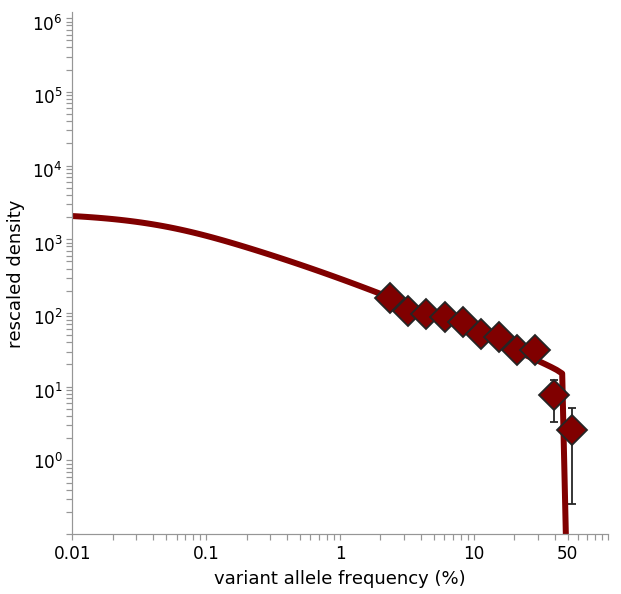

In [27]:
#Plotting the histogram
plt.close('all')
scale = 1.2
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(8*scale, 8*scale))

m_size = 14
Boltonmarkersize = m_size*1.5

line_width = 6
a = 0.75

all468color = 'maroon'
Boltonmarker = 'D'


plot_log_hist_data_for_plot_solid_smaller(all468_gene_non_syn_data, Boltontotal_panel_c, Bolton_468panel_non_syn_mu, n_bins_Bolton, \
                            'Bolton', Boltonmarker, Boltonmarkersize, all468color)



x=np.linspace(-10, np.log(0.49999999), 100)
fitted_VAF_p_free=[logProbtheory_actual_ages_nonsyn_delta_exp_power_p_free(l, list_of_Bolton_ages_largest_panel, p_free_inferred_params) for l in x]
ax1.plot(x, fitted_VAF_p_free, c = 'maroon', lw = line_width, alpha = 1, zorder = 0)

# plt.savefig('Fitted_VAF_p_free_expo_power_delta_all468genes.pdf', bbox_inches='tight')
plt.show()

low_fitness_fraction 0.55990531461202 moderate_fitness_fraction 0.3985530892133756 high_fitness_fraction 0.04154159568605314


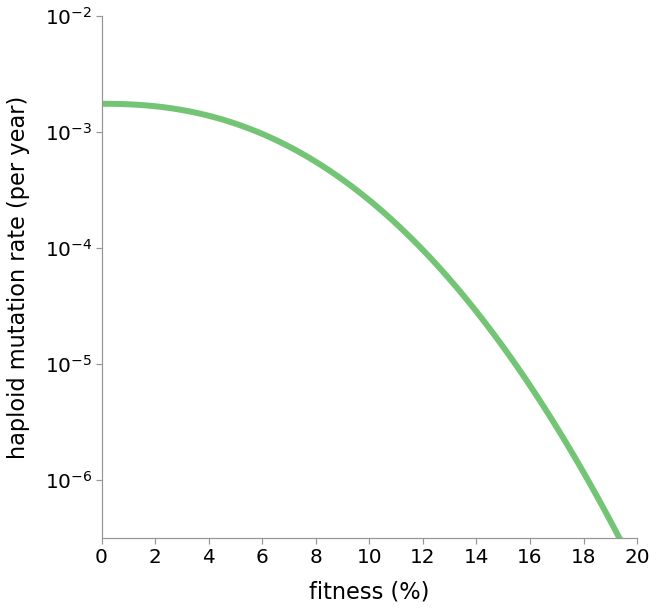

In [45]:
# plot DFE
plt.close('all')
scale = 1.2
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(8*scale, 8*scale))


s_vector = np.linspace(0, 0.2, 100)

# log convex
p = p_free_inferred_params[0]
q = p_free_inferred_params[2]
weight_s= lambda s: np.exp(-((abs(s))/q)**p)
normalization=integrate.quad(weight_s, 0.0, float("inf"))[0]

def DFE(s, params):
    p = params[0]
    q = params[1]
    sigma = params[2]
    
    density = Bolton_468panel_non_syn_mu*sigma*np.exp(-(s/q)**p)/normalization
    
    return density

all_fitness_fraction = integrate.quad(lambda s: DFE(s, p_free_inferred_params), 0, float('inf'))[0]
low_fitness_fraction = integrate.quad(lambda s: DFE(s, p_free_inferred_params), 0, 0.04)[0]
moderate_fitness_fraction = integrate.quad(lambda s: DFE(s, p_free_inferred_params), 0.04, 0.1)[0]
high_fitness_fraction = integrate.quad(lambda s: DFE(s, p_free_inferred_params), 0.1, float('inf'))[0]
print('low_fitness_fraction', low_fitness_fraction/all_fitness_fraction,\
      'moderate_fitness_fraction', moderate_fitness_fraction/all_fitness_fraction,\
      'high_fitness_fraction', high_fitness_fraction/all_fitness_fraction)

DFE_vector = [np.log(DFE(s,p_free_inferred_params)) for s in s_vector]

ax1.plot(s_vector, DFE_vector, c = green3, lw = line_width, alpha = 1, zorder = 0)

ax1.set_xlim(0,0.2)
ax1.set_ylim(np.log(10**-6.5), np.log(10**-2))
ax1.set_xlabel('fitness (%)', fontsize = axislabelfont*1.5, labelpad = 12*scale, fontweight = 'medium')
ax1.set_ylabel('haploid mutation rate (per year)', fontsize = axislabelfont*1.5, labelpad = 12*scale, fontweight = 'medium')

x_major_ticks = [0, 0.02,0.04,0.06,0.08, 0.1,0.12,0.14, 0.16,0.18, 0.2]
x_major_tick_labels = ["0","2","4","6","8","10","12","14","16", "18","20"]
ax1.set_xticks(x_major_ticks)
ax1.set_xticklabels(x_major_tick_labels, fontsize = 20)
ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

y_major_ticks = [np.log(0.000001), np.log(0.00001),np.log(0.0001), np.log(0.001), np.log(0.01)]
y_major_tick_labels = ["$10^{-6}$", "$10^{-5}$", "$10^{-4}$","$10^{-3}$", "$10^{-2}$"]
ax1.set_yticks(y_major_ticks)
ax1.set_yticklabels(y_major_tick_labels, fontsize = 20)
ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

#Only show the required axis lines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(scale)

for axis in ['bottom','left']:
    ax1.spines[axis].set_color(grey3)
        
# plt.savefig('DFE_p_free_expo_power_delta_all468genes.pdf', bbox_inches='tight')

### expo power + delta + p=2,3

In [30]:
p_2_fixed_params = [0.06558015, 0.03017095]
p_3_fixed_params = [0.09221333, 0.01549788]
 

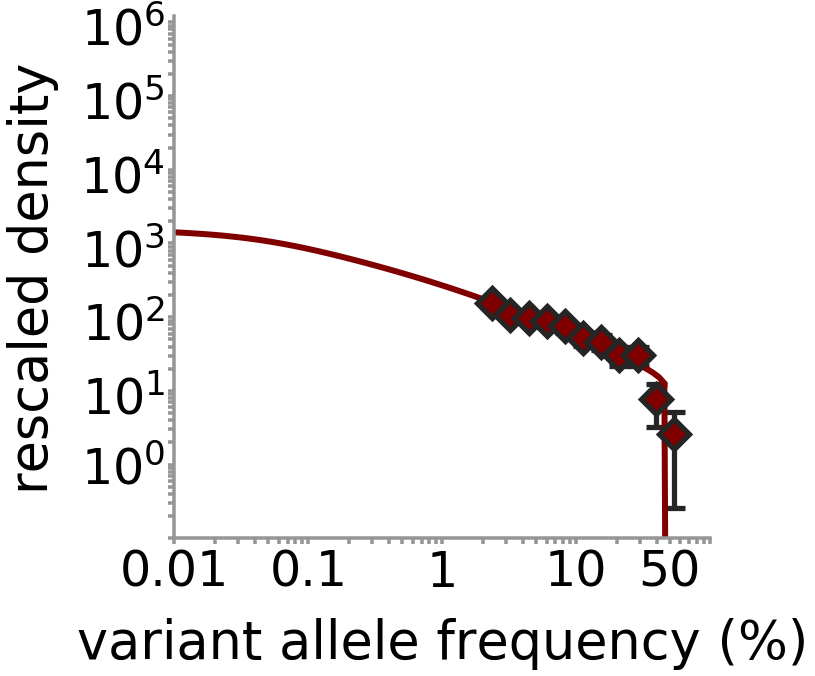

In [53]:
# best-fit nonsynonymous VAF
plt.close('all')
scale = 1.2
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(8*scale, 8*scale))

m_size = 14
Boltonmarkersize = m_size*1.5

line_width = 6
a = 0.75

all468color = 'maroon'
Boltonmarker = 'D'


p2 = 2
p3 = 3

plot_log_hist_data_for_plot_solid_larger(all468_gene_non_syn_data, Boltontotal_panel_c, Bolton_468panel_non_syn_mu, n_bins_Bolton, \
                            'Bolton', Boltonmarker, Boltonmarkersize, all468color, 3.5)



x=np.linspace(-10, np.log(0.4999999999), 100)
# fitted_VAF_p_2_fixed=[logProbtheory_actual_ages_nonsyn_delta_exp_power_log_convex(l, list_of_Bolton_ages_largest_panel, p2, p_2_fixed_params) for l in x]
# ax1.plot(x, fitted_VAF_p_2_fixed, c = 'maroon', lw = line_width, alpha = 1, zorder = 0)

fitted_VAF_p_3_fixed=[logProbtheory_actual_ages_nonsyn_delta_exp_power_log_convex(l, list_of_Bolton_ages_largest_panel, p3, p_3_fixed_params) for l in x]
ax1.plot(x, fitted_VAF_p_3_fixed, c = 'maroon', lw = line_width, alpha = 1, zorder = 0)

# plt.savefig('Fitted_VAF_p_2_expo_power_delta_all468genes.pdf', bbox_inches='tight')
# plt.savefig('Fitted_VAF_p_3_expo_power_delta_all468genes.pdf', bbox_inches='tight')
plt.show()

low_fitness_fraction 0.47607816410458353 moderate_fitness_fraction 0.4587329017958511 high_fitness_fraction 0.0651889340994046


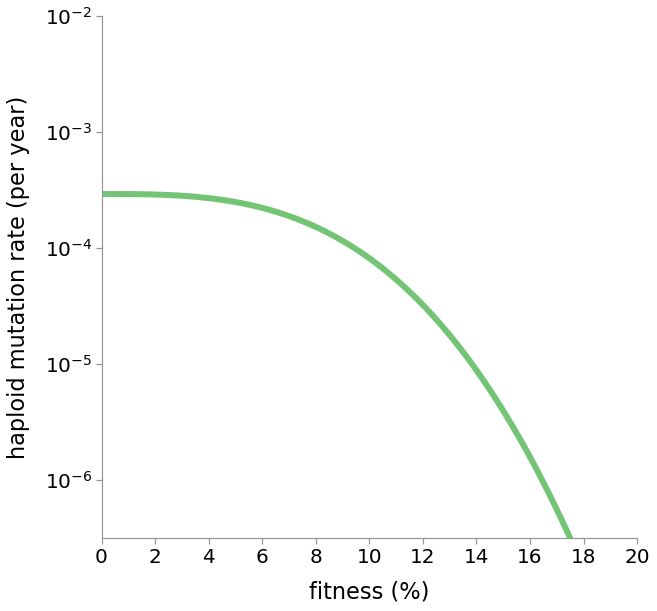

In [49]:
# plot DFE
plt.close('all')
scale = 1.2
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(8*scale, 8*scale))

p_fixed_params= p_3_fixed_params
p = 3

s_vector = np.linspace(0, 0.2, 100)

# log convex

q = p_fixed_params[0]
weight_s= lambda s: np.exp(-((abs(s))/q)**p)
normalization=integrate.quad(weight_s, 0.0, float("inf"))[0]

def DFE(s, params, p):
#     p = params[0]
    q = params[0]
    sigma = params[1]
    
    density = Bolton_468panel_non_syn_mu*sigma*np.exp(-(s/q)**p)/normalization
    
    return density

all_fitness_fraction = integrate.quad(lambda s: DFE(s, p_fixed_params, p), 0, float('inf'))[0]
low_fitness_fraction = integrate.quad(lambda s: DFE(s, p_fixed_params, p), 0, 0.04)[0]
moderate_fitness_fraction = integrate.quad(lambda s: DFE(s, p_fixed_params, p), 0.04, 0.1)[0]
high_fitness_fraction = integrate.quad(lambda s: DFE(s, p_fixed_params, p), 0.1, float('inf'))[0]
print('low_fitness_fraction', low_fitness_fraction/all_fitness_fraction,\
      'moderate_fitness_fraction', moderate_fitness_fraction/all_fitness_fraction,\
      'high_fitness_fraction', high_fitness_fraction/all_fitness_fraction)

DFE_vector = [np.log(DFE(s, p_fixed_params, p)) for s in s_vector]

ax1.plot(s_vector, DFE_vector, c = green3, lw = line_width, alpha = 1, zorder = 0)

ax1.set_xlim(0,0.2)
ax1.set_ylim(np.log(10**-6.5), np.log(10**-2))
ax1.set_xlabel('fitness (%)', fontsize = axislabelfont*1.5, labelpad = 12*scale, fontweight = 'medium')
ax1.set_ylabel('haploid mutation rate (per year)', fontsize = axislabelfont*1.5, labelpad = 12*scale, fontweight = 'medium')

x_major_ticks = [0, 0.02,0.04,0.06,0.08, 0.1,0.12,0.14, 0.16,0.18, 0.2]
x_major_tick_labels = ["0","2","4","6","8","10","12","14","16", "18","20"]
ax1.set_xticks(x_major_ticks)
ax1.set_xticklabels(x_major_tick_labels, fontsize = 20)
ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

y_major_ticks = [np.log(0.000001), np.log(0.00001),np.log(0.0001), np.log(0.001), np.log(0.01)]
y_major_tick_labels = ["$10^{-6}$", "$10^{-5}$", "$10^{-4}$","$10^{-3}$", "$10^{-2}$"]
ax1.set_yticks(y_major_ticks)
ax1.set_yticklabels(y_major_tick_labels, fontsize = 20)
ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

#Only show the required axis lines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(scale)

for axis in ['bottom','left']:
    ax1.spines[axis].set_color(grey3)
        
# plt.savefig('DFE_p_3_expo_power_delta_all468genes.pdf', bbox_inches='tight')

### log concave DFE

C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


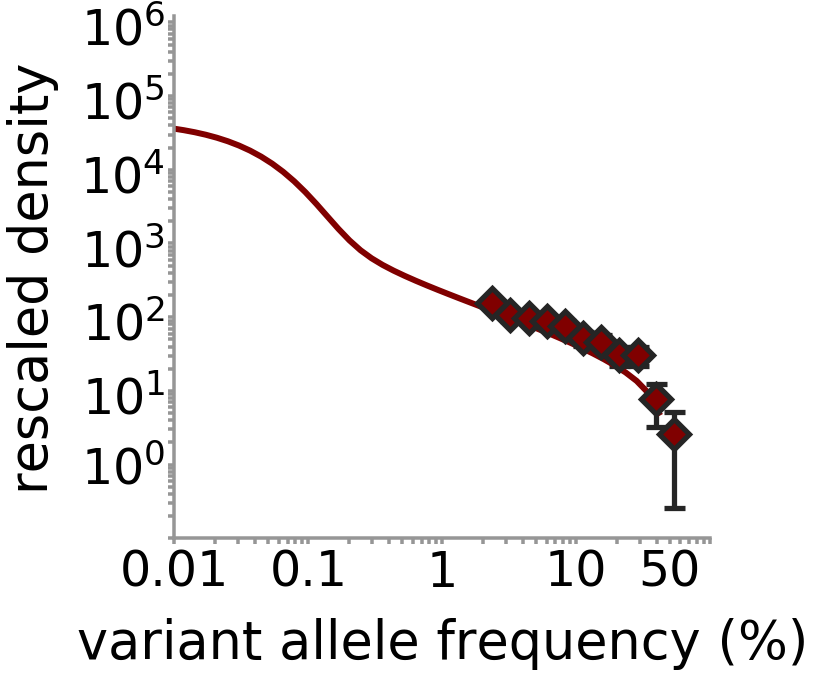

In [30]:
# best-fit nonsynonymous VAF
plt.close('all')
scale = 1.2
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(8*scale, 8*scale))

m_size = 14
Boltonmarkersize = m_size*1.5

line_width = 6
a = 0.75

all468color = 'maroon'
Boltonmarker = 'D'

log_concave_params= [2.58770579e-01, 8.87409733e-06, 1.31516655e-01,  4.73318255e-01]


plot_log_hist_data_for_plot_solid_larger(all468_gene_non_syn_data, Boltontotal_panel_c, Bolton_468panel_non_syn_mu, n_bins_Bolton, \
                            'Bolton', Boltonmarker, Boltonmarkersize, all468color, 3.5)



x=np.linspace(-10, np.log(0.49999999999999999999999999), 50)
fitted_VAF_p_2_fixed=[logProbtheory_actual_ages_nonsyn_delta_exp_power(l, list_of_Bolton_ages_largest_panel, log_concave_params) for l in x]
ax1.plot(x, fitted_VAF_p_2_fixed, c = 'maroon', lw = line_width, alpha = 1, zorder = 0)

# plt.savefig('normal_densities_fit_Fitted_VAF_log_concave_expo_power_delta_all468genes.pdf', bbox_inches='tight')

plt.show()

low_fitness_fraction 0.9810647227375618 moderate_fitness_fraction 0.017235273248712317 high_fitness_fraction 0.001700018578279824


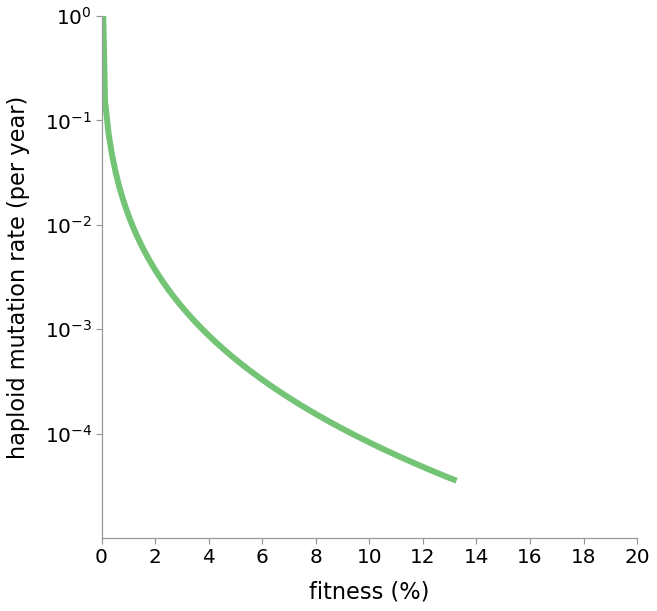

In [28]:
# Plot DFE
plt.close('all')
scale = 1.2
f, (ax1) = plt.subplots(1, 1, sharey=True, figsize=(8*scale, 8*scale))
line_width = 6

Bolton_468panel_mu = 0.0021655198297872344
log_concave_params= [2.58770579e-01, 8.87409733e-06, 1.31516655e-01,  4.73318255e-01]
s_max_inferred=log_concave_params[2]
sigma = log_concave_params[3]

s_vector = np.linspace(0, s_max_inferred, 100)

# log convex

p = log_concave_params[0]
q = log_concave_params[1]
weight_s= lambda s: np.exp(-((abs(s))/q)**p)
normalization=integrate.quad(weight_s, 0.0, s_max_inferred)[0]

def DFE(s):
    
    density =Bolton_468panel_mu*sigma*np.exp(-(s/q)**p)/normalization
    
    return density

all_fitness_fraction = integrate.quad(lambda s: DFE(s), 0, s_max_inferred)[0]
low_fitness_fraction = integrate.quad(lambda s: DFE(s), 0, 0.04)[0]
moderate_fitness_fraction = integrate.quad(lambda s: DFE(s), 0.04, 0.1)[0]
high_fitness_fraction = integrate.quad(lambda s: DFE(s), 0.1, s_max_inferred)[0]
print('low_fitness_fraction', low_fitness_fraction/all_fitness_fraction,\
      'moderate_fitness_fraction', moderate_fitness_fraction/all_fitness_fraction,\
      'high_fitness_fraction', high_fitness_fraction/all_fitness_fraction)

DFE_vector = [np.log(DFE(s)) for s in s_vector]

ax1.plot(s_vector, DFE_vector, c = green3, lw = line_width, alpha = 1, zorder = 0)

ax1.set_xlim(0,0.2)
ax1.set_ylim(np.log(10**-5), np.log(1))
ax1.set_xlabel('fitness (%)', fontsize = axislabelfont*1.5, labelpad = 12*scale, fontweight = 'medium')
ax1.set_ylabel('haploid mutation rate (per year)', fontsize = axislabelfont*1.5, labelpad = 12*scale, fontweight = 'medium')

x_major_ticks = [0, 0.02,0.04,0.06,0.08, 0.1,0.12,0.14, 0.16,0.18, 0.2]
x_major_tick_labels = ["0","2","4","6","8","10","12","14","16", "18","20"]
ax1.set_xticks(x_major_ticks)
ax1.set_xticklabels(x_major_tick_labels, fontsize = 20)
ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

y_major_ticks = [np.log(0.0001), np.log(0.001),np.log(0.01), np.log(0.1), np.log(1)]
y_major_tick_labels = ["$10^{-4}$", "$10^{-3}$", "$10^{-2}$","$10^{-1}$", "$10^{0}$"]
ax1.set_yticks(y_major_ticks)
ax1.set_yticklabels(y_major_tick_labels, fontsize = 20)
ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

#Only show the required axis lines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(scale)

for axis in ['bottom','left']:
    ax1.spines[axis].set_color(grey3)
        
# plt.savefig('normal_densities_DFE_log_concave_expo_power_delta_all468genes.pdf', bbox_inches='tight')